#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [40]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [41]:
import os

# MyDrive 루트에 있는 파일/폴더 목록 확인
print(os.listdir('/content/drive/MyDrive/'))


['Google Photo.zip', 'server.zip', '컴활1급', 'Colab Notebooks', 'project3', 'sort_data.csv']


In [42]:
# 주어진 데이터 셋을 불러오세요.(3개)
df_train = pd.read_csv(path + 'data01_train.csv')
df_test = pd.read_csv(path + 'data01_test.csv')
df_feature = pd.read_csv(path + 'features.csv')

#불필요한 칼럼을 삭제하세요.
df_train.drop('subject', axis=1, inplace=True)
df_test.drop('subject', axis=1, inplace=True)

import_data = pd.read_csv('/content/import_sort_data.csv') #변수 중요도를 정렬한 파일
cols = list(import_data['feature_name'][:210])+list(['Activity'])
df_train = df_train[cols]
df_test = df_test[cols]

#### 2) 기본 정보 조회

In [43]:
#전체 데이터의 행,열 개수 확인
df_train.shape

(5881, 211)

In [44]:
#전체 데이터의 상위 5개 행 확인
df_train.head()

,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-Y,...,fBodyGyro-mean()-Y,tBodyGyro-energy()-Z,"fBodyAccJerk-bandsEnergy()-1,8.2",tBodyAcc-mad()-Y,"fBodyGyro-bandsEnergy()-25,48.2",fBodyBodyGyroMag-meanFreq(),fBodyAcc-max()-Y,fBodyBodyGyroMag-energy(),fBodyGyro-std()-Y,Activity
0,-0.601120,0.673768,-0.334921,0.331298,-0.370494,0.875254,0.805627,0.891969,-0.358842,-0.775936,...,-0.974264,-0.999479,-0.999709,-0.962596,-0.999906,-0.248487,-0.963993,-0.999448,-0.965697,STANDING
1,0.345205,-0.893830,0.937432,-0.769186,0.873312,-0.134711,-0.200892,-0.095343,0.924656,0.714508,...,-0.978759,-0.999887,-0.999932,-0.993870,-0.999960,-0.288496,-0.996704,-0.999576,-0.975541,LAYING
2,-0.833564,0.906252,-0.145801,0.202434,-0.195671,0.965965,0.891615,0.985606,-0.174095,-0.953043,...,-0.995670,-0.999876,-0.999963,-0.982187,-0.999943,0.375361,-0.991351,-0.999940,-0.996758,STANDING
3,-0.695819,0.805419,-0.275699,0.287154,-0.309430,0.927343,0.858160,0.943954,-0.297703,-0.849096,...,-0.463715,-0.808021,-0.899938,0.014245,-0.877453,0.136491,-0.231513,-0.849297,-0.417537,WALKING
4,-0.705029,0.738738,-0.263482,0.264952,-0.236084,0.901125,0.858531,0.901943,-0.260540,-0.885215,...,-0.619732,-0.819772,-0.870319,-0.109680,-0.984466,-0.350359,-0.431145,-0.714778,-0.551035,WALKING_DOWNSTAIRS


In [45]:
#전체 데이터의 수치형 변수 분포 확인
df_train.describe()

,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-Y,...,tGravityAcc-std()-Z,fBodyGyro-mean()-Y,tBodyGyro-energy()-Z,"fBodyAccJerk-bandsEnergy()-1,8.2",tBodyAcc-mad()-Y,"fBodyGyro-bandsEnergy()-25,48.2",fBodyBodyGyroMag-meanFreq(),fBodyAcc-max()-Y,fBodyBodyGyroMag-energy(),fBodyGyro-std()-Y
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,-0.491501,0.439477,0.022675,0.059299,-0.004537,0.666745,0.606499,0.681231,0.009978,-0.731231,...,-0.937118,-0.702085,-0.872339,-0.896305,-0.525944,-0.967436,-0.042947,-0.659080,-0.874650,-0.667093
std,0.509069,0.695108,0.368885,0.297340,0.360235,0.513944,0.507429,0.505871,0.371786,0.437070,...,0.107939,0.345304,0.194447,0.174958,0.485115,0.072986,0.282502,0.352440,0.192295,0.382523
min,-1.000000,-1.000000,-0.568157,-1.000000,-0.493874,-0.946566,-0.992959,-0.986149,-0.535222,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.999419,-1.000000,-0.997500,-1.000000,-1.000000,-1.000000
25%,-0.811397,0.507857,-0.223971,-0.018203,-0.246212,0.806501,0.745482,0.807381,-0.239082,-0.966231,...,-0.986906,-0.986119,-0.999788,-0.999781,-0.977865,-0.999953,-0.237470,-0.980256,-0.999728,-0.982566
50%,-0.709441,0.785454,-0.129579,0.182893,-0.153714,0.919511,0.857192,0.926703,-0.144690,-0.910300,...,-0.966355,-0.922290,-0.983179,-0.997188,-0.849266,-0.998898,-0.057155,-0.868836,-0.985823,-0.910677
75%,-0.511330,0.872237,0.141056,0.248435,0.138519,0.952970,0.886738,0.964898,0.147751,-0.769013,...,-0.928554,-0.469506,-0.786903,-0.854529,-0.068857,-0.961249,0.151467,-0.354598,-0.802629,-0.426421
max,0.977344,0.975855,1.000000,0.478157,0.968307,0.991549,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.967664,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
#전체 데이터의 모든 변수 확인
df_train.columns

Index(['angle(X,gravityMean)', 'tGravityAcc-energy()-X', 'tGravityAcc-min()-Y',
       'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'tGravityAcc-mean()-X',
       'tGravityAcc-max()-X', 'tGravityAcc-min()-X', 'tGravityAcc-mean()-Y',
       'tGravityAcc-energy()-Y',
       ...
       'fBodyGyro-mean()-Y', 'tBodyGyro-energy()-Z',
       'fBodyAccJerk-bandsEnergy()-1,8.2', 'tBodyAcc-mad()-Y',
       'fBodyGyro-bandsEnergy()-25,48.2', 'fBodyBodyGyroMag-meanFreq()',
       'fBodyAcc-max()-Y', 'fBodyBodyGyroMag-energy()', 'fBodyGyro-std()-Y',
       'Activity'],
      dtype='object', length=211)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [47]:
display(df_train['Activity'].value_counts()/len(df_train['Activity']))
display(df_test['Activity'].value_counts())

,count
Activity,
LAYING,0.189594
STANDING,0.184833
SITTING,0.175480
WALKING,0.169699
WALKING_UPSTAIRS,0.145894
WALKING_DOWNSTAIRS,0.134501


,count
Activity,
LAYING,292
STANDING,287
SITTING,254
WALKING,228
WALKING_UPSTAIRS,215
WALKING_DOWNSTAIRS,195


In [48]:
def assign_dynamic_label(df):
    df['is_dynamic'] = np.where(df['Activity'].isin(['STANDING', 'SITTING', 'LAYING']), 0, 1)
    return df

df_train = assign_dynamic_label(df_train)
df_test = assign_dynamic_label(df_test)

print(df_train['is_dynamic'].value_counts())
print(df_test['is_dynamic'].value_counts())

is_dynamic
0    3234
1    2647
Name: count, dtype: int64
is_dynamic
0    833
1    638
Name: count, dtype: int64


### (2) x, y 분리

In [49]:
# 1단계 모델 데이터 준비 (전체 데이터)
x = df_train.drop(['is_dynamic', 'Activity'], axis=1)
y = df_train['is_dynamic']

x_test_all = df_test.drop(['is_dynamic', 'Activity'], axis=1)
y_test_all = df_test['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [50]:
x.head()

,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-Y,...,tGravityAcc-std()-Z,fBodyGyro-mean()-Y,tBodyGyro-energy()-Z,"fBodyAccJerk-bandsEnergy()-1,8.2",tBodyAcc-mad()-Y,"fBodyGyro-bandsEnergy()-25,48.2",fBodyBodyGyroMag-meanFreq(),fBodyAcc-max()-Y,fBodyBodyGyroMag-energy(),fBodyGyro-std()-Y
0,-0.601120,0.673768,-0.334921,0.331298,-0.370494,0.875254,0.805627,0.891969,-0.358842,-0.775936,...,-0.970475,-0.974264,-0.999479,-0.999709,-0.962596,-0.999906,-0.248487,-0.963993,-0.999448,-0.965697
1,0.345205,-0.893830,0.937432,-0.769186,0.873312,-0.134711,-0.200892,-0.095343,0.924656,0.714508,...,-0.988593,-0.978759,-0.999887,-0.999932,-0.993870,-0.999960,-0.288496,-0.996704,-0.999576,-0.975541
2,-0.833564,0.906252,-0.145801,0.202434,-0.195671,0.965965,0.891615,0.985606,-0.174095,-0.953043,...,-0.997672,-0.995670,-0.999876,-0.999963,-0.982187,-0.999943,0.375361,-0.991351,-0.999940,-0.996758
3,-0.695819,0.805419,-0.275699,0.287154,-0.309430,0.927343,0.858160,0.943954,-0.297703,-0.849096,...,-0.953040,-0.463715,-0.808021,-0.899938,0.014245,-0.877453,0.136491,-0.231513,-0.849297,-0.417537
4,-0.705029,0.738738,-0.263482,0.264952,-0.236084,0.901125,0.858531,0.901943,-0.260540,-0.885215,...,-0.621825,-0.619732,-0.819772,-0.870319,-0.109680,-0.984466,-0.350359,-0.431145,-0.714778,-0.551035


In [51]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
from sklearn.preprocessing import StandardScaler
scaler_stage1 = StandardScaler()
x_scaled = scaler_stage1.fit_transform(x)
x_test_stage1 = scaler_stage1.transform(x_test_all)

### (4) 데이터 분할
* train, val 분할

In [52]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, stratify=y)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4704, 210) (1177, 210) (4704,) (1177,)


## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [82]:
# 모델 설계
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization


model_stage1 = Sequential()
model_stage1.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model_stage1.add(Dropout(0.5))
model_stage1.add(BatchNormalization())
model_stage1.add(Dense(128, activation='relu'))
model_stage1.add(Dropout(0.5))
model_stage1.add(BatchNormalization())
model_stage1.add(Dense(64, activation='relu'))
model_stage1.add(Dropout(0.5))
model_stage1.add(BatchNormalization())
model_stage1.add(Dense(32, activation='relu'))
model_stage1.add(Dropout(0.5))
model_stage1.add(BatchNormalization())
# 마지막 레이어: sigmoid 활성화 사용. 따라서 from_logits=False 로 설정해야 함.
model_stage1.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model_stage1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 256)            │        54,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,201 (387.50 KB)

 Trainable params: 98,241 (383.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [83]:
# 컴파일 및 학습
LEARNING_RATE_1 = 5e-4
EPOCHS_1 = 200
BATCH_SIZE = 128

train_dataset_stage1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
val_dataset_stage1 = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
train_dataset_stage1 = train_dataset_stage1.prefetch(tf.data.AUTOTUNE)
val_dataset_stage1 = val_dataset_stage1.prefetch(tf.data.AUTOTUNE)
test_dataset_stage1 = tf.data.Dataset.from_tensor_slices((x_test_stage1, y_test_all)).batch(BATCH_SIZE)

model_stage1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=LEARNING_RATE_1),
    metrics=['accuracy']
)

es1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, verbose=1, restore_best_weights=True)
redu1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 클래스 가중치 계산
class_weights_stage1 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_stage1 = dict(enumerate(class_weights_stage1))

# 모델 학습 및 history 저장
history = model_stage1.fit(
    train_dataset_stage1,
    validation_data=val_dataset_stage1,
    epochs=EPOCHS_1,
    callbacks=[es1, redu1],
    class_weight=class_weights_stage1
)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.6518 - loss: 0.6429 - val_accuracy: 0.9966 - val_loss: 0.1477 - learning_rate: 5.0000e-04
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9164 - loss: 0.2849 - val_accuracy: 1.0000 - val_loss: 0.0398 - learning_rate: 5.0000e-04
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9769 - loss: 0.1707 - val_accuracy: 1.0000 - val_loss: 0.0184 - learning_rate: 5.0000e-04
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9907 - loss: 0.1146 - val_accuracy: 1.0000 - val_loss: 0.0125 - learning_rate: 5.0000e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0878 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 5.0000e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0705 - val_accuracy: 1.0000 - val_loss: 0.0089 - learning_rate: 5.0000e-04
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986

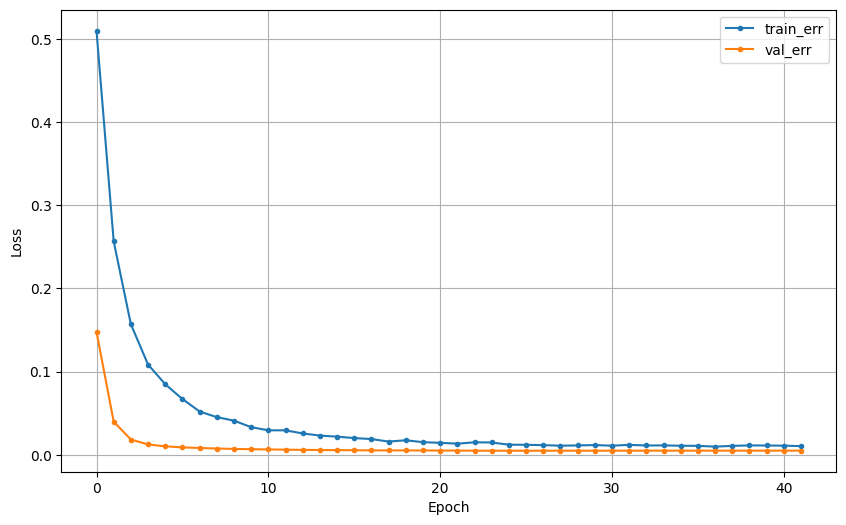

In [84]:
# 학습곡선
dl_history_plot(history.history)

In [80]:
# 예측 및 평가
model_stage1.evaluate(x_test_stage1, y_test_all)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0047


[0.004674029536545277, 1.0]

#### 2) 모델2

In [ ]:
# 모델 설계

model2 = tf.keras.Sequential()
model2.add(Dense(512, input_dim=x_train.shape[1], activation='relu')) # x_train.shape[1] = 칼럼수
model2.add(tf.keras.layers.Dropout(0.5))  # Dropout 으로 규제(과적합 방지)
model2.add(Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # l2 규제 : 과적합 방지 목적, 손실함수에 패널티를 가함
model2.summary()

In [ ]:
# 컴파일 및 학습
LEARINIG_RATE = 1e-4
EPOCHS = 200
BATCH_SIZE = 64


model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=Adam(learning_rate=LEARINIG_RATE), metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[es, Redu],
    class_weight=class_weights
    )

In [ ]:
# 학습곡선
dl_history_plot(model2.history.history)

In [ ]:
# 예측 및 평가
print(model2.evaluate(x_test,y_test))

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [59]:
# (tip) 정적 행동(0)인 데이터 추출
df_train_static = df_train[df_train['is_dynamic'] == 0].copy()
df_test_static = df_test[df_test['is_dynamic'] == 0].copy()

print(df_test_static['Activity'].value_counts())

Activity
LAYING      292
STANDING    287
SITTING     254
Name: count, dtype: int64


In [60]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
label_encoder_static = LabelEncoder()
df_train_static['Activity'] = label_encoder_static.fit_transform(df_train_static['Activity'])
df_test_static['Activity'] = label_encoder_static.transform(df_test_static['Activity'])

x_train_static = df_train_static.drop(['is_dynamic', 'Activity'], axis=1)
y_train_static = df_train_static['Activity']
x_test_static = df_test_static.drop(['is_dynamic', 'Activity'], axis=1)
y_test_static = df_test_static['Activity']

x_train_static, x_val_static, y_train_static, y_val_static = train_test_split(
    x_train_static, y_train_static, test_size=0.2, stratify=y_train_static
)
print(x_train_static.shape, x_val_static.shape, y_train_static.shape, y_val_static.shape)

# stage2: 전용 scaler (정적 모델에 대해 따로 학습)
scaler_static = StandardScaler()
x_train_static_scaled = scaler_static.fit_transform(x_train_static)
x_val_static_scaled = scaler_static.transform(x_val_static)
x_test_static_scaled = scaler_static.transform(x_test_static)

(2587, 210) (647, 210) (2587,) (647,)


In [85]:
# 모델 설계
import tensorflow as tf

model_static = Sequential()
model_static.add(Dense(256, input_dim=x_train_static_scaled.shape[1], activation='relu'))
model_static.add(Dropout(0.5))
model_static.add(BatchNormalization())
model_static.add(Dense(128, activation='relu'))
model_static.add(Dropout(0.5))
model_static.add(BatchNormalization())
model_static.add(Dense(64, activation='relu'))
model_static.add(Dropout(0.5))
model_static.add(BatchNormalization())
model_static.add(Dense(32, activation='relu'))
model_static.add(Dropout(0.5))
model_static.add(BatchNormalization())
model_static.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model_static.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │        54,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,267 (387.76 KB)

 Trainable params: 98,307 (384.01 KB)

 Non-trainable params: 960 (3.75 KB)

In [86]:
# 컴파일 및 학습
LEARNING_RATE_STATIC = 3e-4
EPOCHS_STATIC = 200

train_dataset_static = tf.data.Dataset.from_tensor_slices((x_train_static_scaled, y_train_static)).shuffle(len(x_train_static_scaled)).batch(BATCH_SIZE)
val_dataset_static = tf.data.Dataset.from_tensor_slices((x_val_static_scaled, y_val_static)).batch(BATCH_SIZE)
train_dataset_static = train_dataset_static.prefetch(tf.data.AUTOTUNE)
val_dataset_static = val_dataset_static.prefetch(tf.data.AUTOTUNE)
test_dataset_static = tf.data.Dataset.from_tensor_slices((x_test_static_scaled, y_test_static)).batch(BATCH_SIZE)

model_static.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=LEARNING_RATE_STATIC),
    metrics=['accuracy']
)

es_static = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, verbose=1, restore_best_weights=True)
redu_static = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_static = model_static.fit(
    train_dataset_static,
    validation_data=val_dataset_static,
    epochs=EPOCHS_STATIC,
    callbacks=[es_static, redu_static]
)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.3551 - loss: 1.5076 - val_accuracy: 0.5410 - val_loss: 1.0004 - learning_rate: 3.0000e-04
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3883 - loss: 1.3987 - val_accuracy: 0.7233 - val_loss: 0.8772 - learning_rate: 3.0000e-04
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4290 - loss: 1.3012 - val_accuracy: 0.7821 - val_loss: 0.7798 - learning_rate: 3.0000e-04
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4719 - loss: 1.1486 - val_accuracy: 0.7991 - val_loss: 0.7002 - learning_rate: 3.0000e-04
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5194 - loss: 1.0366 - val_accuracy: 0.8022 - val_loss: 0.6423 - learning_rate: 3.0000e-04
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5387 - loss: 1.0252 - val_accuracy: 0.8145 - val_loss: 0.5906 - learning_rate: 3.0000e-04
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.55

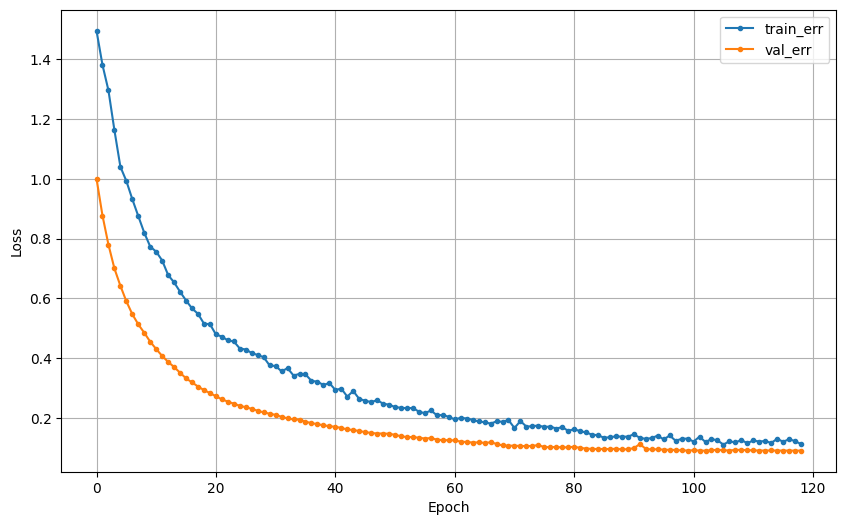

In [87]:
# # 학습곡선
dl_history_plot(history_static.history)

In [88]:
# 예측 및 평가
model_static.evaluate(x_test_static_scaled, y_test_static)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9685 - loss: 0.0901


[0.08113792538642883, 0.9699879884719849]

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [63]:
# (tip) 동적 행동(1)인 데이터 추출
df_train_dynamic = df_train[df_train['is_dynamic'] == 1].copy()
df_test_dynamic = df_test[df_test['is_dynamic'] == 1].copy()

print(df_test_dynamic['Activity'].value_counts())

Activity
WALKING               228
WALKING_UPSTAIRS      215
WALKING_DOWNSTAIRS    195
Name: count, dtype: int64


In [64]:
# (tip) map 활용해서 숫자레이블로 매핑
label_encoder_dynamic = LabelEncoder()
df_train_dynamic['Activity'] = label_encoder_dynamic.fit_transform(df_train_dynamic['Activity'])
df_test_dynamic['Activity'] = label_encoder_dynamic.transform(df_test_dynamic['Activity'])

x_train_dynamic = df_train_dynamic.drop(['is_dynamic', 'Activity'], axis=1)
y_train_dynamic = df_train_dynamic['Activity']
x_test_dynamic = df_test_dynamic.drop(['is_dynamic', 'Activity'], axis=1)
y_test_dynamic = df_test_dynamic['Activity']

x_train_dynamic, x_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(
    x_train_dynamic, y_train_dynamic, test_size=0.2, stratify=y_train_dynamic
)
print(x_train_dynamic.shape, x_val_dynamic.shape, y_train_dynamic.shape, y_val_dynamic.shape)

# stage2: 전용 scaler (동적 모델 전용)
scaler_dynamic = StandardScaler()
x_train_dynamic_scaled = scaler_dynamic.fit_transform(x_train_dynamic)
x_val_dynamic_scaled = scaler_dynamic.transform(x_val_dynamic)
x_test_dynamic_scaled = scaler_dynamic.transform(x_test_dynamic)

(2117, 210) (530, 210) (2117,) (530,)


In [89]:
# 모델 설계
model_dynamic = Sequential()
model_dynamic.add(Dense(256, input_dim=x_train_dynamic_scaled.shape[1], activation='relu'))
model_dynamic.add(Dropout(0.5))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dense(128, activation='relu'))
model_dynamic.add(Dropout(0.5))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dense(64, activation='relu'))
model_dynamic.add(Dropout(0.5))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dense(32, activation='relu'))
model_dynamic.add(Dropout(0.5))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model_dynamic.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 256)            │        54,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,267 (387.76 KB)

 Trainable params: 98,307 (384.01 KB)

 Non-trainable params: 960 (3.75 KB)

In [90]:
# 컴파일 및 학습
LEARNING_RATE_DYNAMIC = 3e-4
EPOCHS_DYNAMIC = 200

train_dataset_dynamic = tf.data.Dataset.from_tensor_slices((x_train_dynamic_scaled, y_train_dynamic)).shuffle(len(x_train_dynamic_scaled)).batch(BATCH_SIZE)
val_dataset_dynamic = tf.data.Dataset.from_tensor_slices((x_val_dynamic_scaled, y_val_dynamic)).batch(BATCH_SIZE)
train_dataset_dynamic = train_dataset_dynamic.prefetch(tf.data.AUTOTUNE)
val_dataset_dynamic = val_dataset_dynamic.prefetch(tf.data.AUTOTUNE)

model_dynamic.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=LEARNING_RATE_DYNAMIC),
    metrics=['accuracy']
)

es_dynamic = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, verbose=1, restore_best_weights=True)
redu_dynamic = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 클래스 가중치 계산
class_weights_dynamic = compute_class_weight('balanced', classes=np.unique(y_train_dynamic), y=y_train_dynamic)
class_weights_dynamic = dict(enumerate(class_weights_dynamic))

history_dynamic = model_dynamic.fit(
    train_dataset_dynamic,
    validation_data=val_dataset_dynamic,
    epochs=EPOCHS_DYNAMIC,
    callbacks=[es_dynamic, redu_dynamic],
    class_weight=class_weights_dynamic
)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.3358 - loss: 1.5488 - val_accuracy: 0.6811 - val_loss: 0.9450 - learning_rate: 3.0000e-04
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3907 - loss: 1.3283 - val_accuracy: 0.8189 - val_loss: 0.8102 - learning_rate: 3.0000e-04
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4601 - loss: 1.1848 - val_accuracy: 0.8434 - val_loss: 0.6998 - learning_rate: 3.0000e-04
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4936 - loss: 1.1126 - val_accuracy: 0.8623 - val_loss: 0.6077 - learning_rate: 3.0000e-04
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5594 - loss: 0.9689 - val_accuracy: 0.8736 - val_loss: 0.5321 - learning_rate: 3.0000e-04
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6044 - loss: 0.8752 - val_accuracy: 0.8811 - val_loss: 0.4703 - learning_rate: 3.0000e-04
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.62

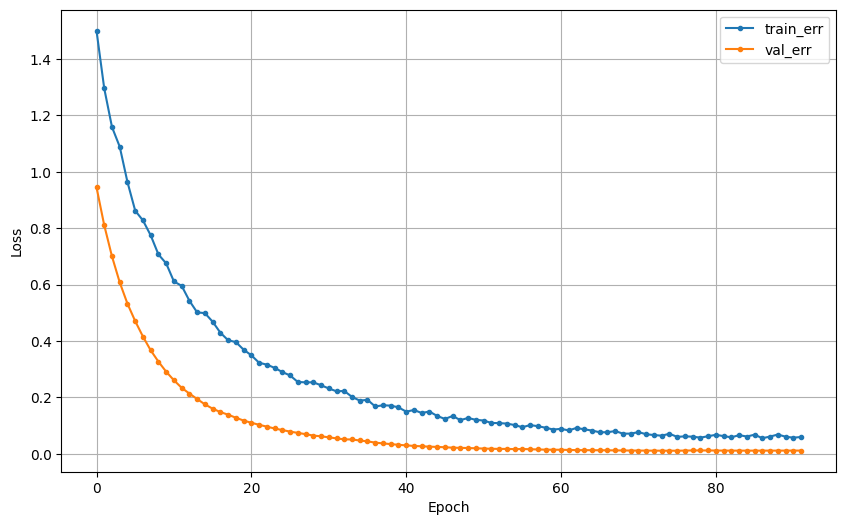

In [91]:
# 학습곡선
dl_history_plot(history_dynamic.history)

In [92]:
# 예측 및 평가
model_dynamic.evaluate(x_test_dynamic_scaled, y_test_dynamic)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9971 - loss: 0.0179


[0.017245985567569733, 0.9968652129173279]

### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [93]:
# 동적 행동 분류 레이블
def mini_project_1(test_df, model_stage1, model_static, model_dynamic,
                   scaler_stage1, scaler_static, scaler_dynamic,
                   label_encoder_static, label_encoder_dynamic):
    """
    test_df: 원본 test DataFrame (is_dynamic, Activity 컬럼 포함)
    모델들: stage1 (정적/동적 분류), 정적 모델, 동적 모델
    scaler_stage1: stage1 전용 스케일러
    scaler_static: 정적 모델 전용 스케일러
    scaler_dynamic: 동적 모델 전용 스케일러
    label_encoder_static, label_encoder_dynamic: 각 모델에 적용한 LabelEncoder (매핑 확인용)
    """
    from sklearn.metrics import classification_report, accuracy_score
    import numpy as np

    # 인덱스 재설정
    test_df = test_df.reset_index(drop=True)
    X_test = test_df.drop(columns=['Activity', 'is_dynamic'])

    # Stage1 예측
    X_test_stage1 = scaler_stage1.transform(X_test)
    stage1_preds = model_stage1.predict(X_test_stage1, verbose=0)
    stage1_classes = (stage1_preds > 0.5).astype(int).flatten()

    # LabelEncoder로부터 매핑 추출
    mapping_static = dict(zip(label_encoder_static.classes_, label_encoder_static.transform(label_encoder_static.classes_)))
    mapping_dynamic = dict(zip(label_encoder_dynamic.classes_, label_encoder_dynamic.transform(label_encoder_dynamic.classes_)))

    # 최종 결과를 저장할 리스트
    final_preds = [None] * len(X_test)

    # 라벨 매핑 (LabelEncoder 결과에 맞게 조정)
    label_map_static = { mapping_static.get('SITTING', None): 'SITTING',
                         mapping_static.get('STANDING', None): 'STANDING',
                         mapping_static.get('LAYING', None): 'LAYING' }
    label_map_dynamic = { mapping_dynamic.get('WALKING', None): 'WALKING',
                          mapping_dynamic.get('WALKING_UPSTAIRS', None): 'WALKING_UPSTAIRS',
                          mapping_dynamic.get('WALKING_DOWNSTAIRS', None): 'WALKING_DOWNSTAIRS' }

    # 정적/동적 인덱스 분리
    static_idx = np.where(stage1_classes == 0)[0]
    dynamic_idx = np.where(stage1_classes == 1)[0]

    # 정적 모델 예측
    if len(static_idx) > 0:
        X_static = X_test.iloc[static_idx]
        X_static_scaled = scaler_static.transform(X_static)
        static_preds = model_static.predict(X_static_scaled, verbose=0)
        static_classes = np.argmax(static_preds, axis=1)
        static_labels = [label_map_static.get(c, None) for c in static_classes]
        for i, idx in enumerate(static_idx):
            final_preds[idx] = static_labels[i]

    # 동적 모델 예측
    if len(dynamic_idx) > 0:
        X_dynamic = X_test.iloc[dynamic_idx]
        X_dynamic_scaled = scaler_dynamic.transform(X_dynamic)
        dynamic_preds = model_dynamic.predict(X_dynamic_scaled, verbose=0)
        dynamic_classes = np.argmax(dynamic_preds, axis=1)
        dynamic_labels = [label_map_dynamic.get(c, None) for c in dynamic_classes]
        for i, idx in enumerate(dynamic_idx):
            final_preds[idx] = dynamic_labels[i]

    # 최종 성능 평가 결과 출력
    y_true = test_df['Activity'].values
    print("\n[최종 성능 평가 결과]")
    print(classification_report(y_true, final_preds, digits=4))
    print("정확도:", accuracy_score(y_true, final_preds))

    return final_preds


#### 2) test 셋으로 예측하고 평가하기

In [94]:
final_predictions = mini_project_1(
    test_df=df_test,
    model_stage1=model_stage1,
    model_static=model_static,
    model_dynamic=model_dynamic,
    scaler_stage1=scaler_stage1,
    scaler_static=scaler_static,
    scaler_dynamic=scaler_dynamic,
    label_encoder_static=label_encoder_static,
    label_encoder_dynamic=label_encoder_dynamic
)


[최종 성능 평가 결과]
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       292
           SITTING     0.9421    0.9606    0.9513       254
          STANDING     0.9645    0.9477    0.9561       287
           WALKING     0.9956    0.9956    0.9956       228
WALKING_DOWNSTAIRS     1.0000    1.0000    1.0000       195
  WALKING_UPSTAIRS     0.9953    0.9953    0.9953       215

          accuracy                         0.9816      1471
         macro avg     0.9829    0.9832    0.9830      1471
      weighted avg     0.9817    0.9816    0.9817      1471

정확도: 0.981645139360979
